# Demand Analysis and Forecasting Using GLMs

This notebook demonstrates how to create an interpretable demand forecasting model that can be used for causal analysis of various factors such as prices.

### Use Case
We have historical sales data for multiple items (SKUs, products, etc.). Each item is represented by one metric time series (e.g. revenue or units sold) and covariates such as item price. We also assume that items can be interdependent. For example, price change on one item can influence the demand on other items. We have two goals:
   * Estimate the effect of covariates on the metrics (e.g. how price change by 1% impacts the demand)
   * Forecast the demand time series based on known covariates

### Prototype: Approach and Data
We use the generalized linear models (GLMs). This is a simple yet powerful approach for demand modeling applications. It is particularly suitable for application such as price optimization where we need not only to forecast the demand, but estimate and interpret the effect of the covariates. We build to models:
   * Aggregate response model for evaluating the effect of individual covariates, e.g. `log(item_1_demand) ~ log(item_2_price)`
   * More complete time series forecasting model that includes calendar features and lags, e.g. `log(item_1_demand_t) ~ log(item_1_price_t) + log(item_2_price_t) + is_weekend + ...`
  
We use a simulator that provides high level of control over demand patterns and covariate effects enabling one to inspect and tune the models in a clean environment.

### Usage and Productization
We use basic GMLs that provide high scalability. Productization of this solution can include the following changes/extensions:
  * Exploratory data analysis can be enhanced with Granger causality tests
  * Bayesian regression should be used instead of frequentist OLS
  * Item attributes and/or embeddings can be added to support forecasting for new and slow-moving items
  * Advanced calendar features and lags should be added

In [304]:
#
# Imports and settings
#
import numpy as np
import pandas as pd
from functools import partial
from tabulate import tabulate

import statsmodels.formula.api as smf

from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")
colors = sns.color_palette()

#
# Helper functions
#

# Highlight weekends on a time series chart
def highlight_weekends(ax, color='k', alpha=0.1):
    ax.set_ylim(*ax.get_ylim())
    xmin, xmax = ax.get_xlim()
    days = np.arange(np.floor(xmin), np.ceil(xmax) + 2)
    weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
    ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor=color, alpha=alpha)
    ax.set_xlim(xmin, xmax)

# Custom dataframe printing function    
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

---
## Data Generation

We create a configuration-driven data generator (simulator) that supports multiple items and shared covariates to model cross-item effects/dependencies.

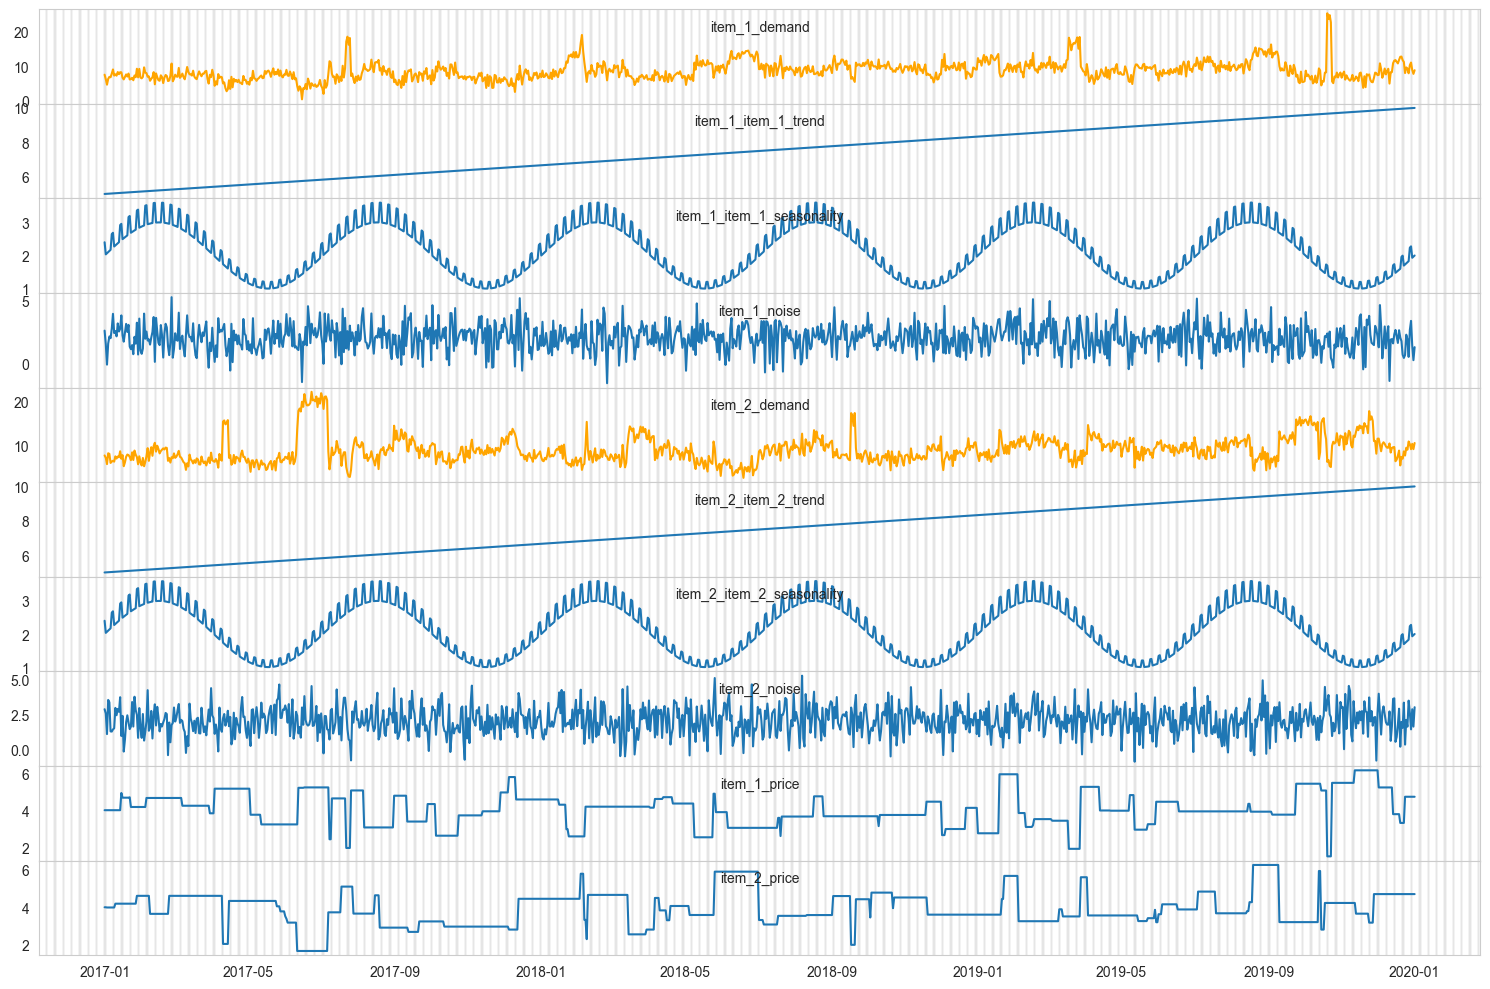

In [176]:
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

#
# Covariate effect functions
#
def multiplicative_effect(x, z, a):
    """
    Multiplicative power-law effect of a covariate z on x
     
    Compute element-wise y = x * z^a where a is a scalar, and x and z are vectors. 
    This equivalent to log(y) = a * log(z) + log(x)
    """
    return x * np.power(z, np.full_like(z, a))

def additive_effect(x, z, b):
    """
    Simple additive effect of a covariate z on x 
    """
    return x + b*z

#
# Data generation function
#
def create_data(demand_spec, start_date, end_date):
    idx = pd.date_range(start=start_date, end=end_date, freq='D') 
    df = pd.DataFrame(index=idx, dtype=float)
    n = len(df.index)
    
    # Generate covariates
    covariates = {}
    for name, func in demand_spec['covariates'].items():
        covariates[name] = func(n)
    
    for item_id, spec in demand_spec['items'].items():
        base_components = {}
        for cname, func in spec['base'].items():
            component = np.zeros(n)
            for i in range(n):
                component[i] = func(idx, i)
            base_components[f'{item_id}_{cname}'] = component
        
        # Synthesize the baseline demand    
        demand = np.sum(list(base_components.values()), axis=0)
    
        # Apply covariate effects
        for cov_name, effect_func in spec['covariates'].items():
            demand = effect_func(demand, covariates[cov_name])
    
        # Add noise
        noise = [spec['noise'](idx, i) for i in range(n)]
        demand += noise
    
        df[f'{item_id}_demand'] = demand
        for comp_name, c in base_components.items():
            df[f'{item_id}_{comp_name}'] = c
        df[f'{item_id}_noise'] = noise
    
    for cov_name, covariate_series in covariates.items():
        df[cov_name] = covariate_series
    
    return df

#
# Generation parameters
#
def seasonal_component(date_idx, i):
    days_year, quarters_year = 365, 4
    s = 2.0 + np.sin(np.pi * i/days_year*quarters_year)
    if date_idx[i].dayofweek > 4:
        s *= 1.2
    
    return s

#
# We assume that item's own price has a positive multiplicative effect,
# and other items' prices have negative effect (cannibalization) 
#
demand_spec = {
    "covariates": { # covariates can be shared across the items
        "item_1_price": partial(step_series, mean=4, scale=1.0, n_steps=80),    
        "item_2_price": partial(step_series, mean=4, scale=1.0, n_steps=80)    
    },
    "items": {
        "item_1": {
            "base": {
                "trend": lambda date_idx, i: 5 + 5.0 * i/len(date_idx),
                "seasonality": seasonal_component
            },
            "covariates": {
                "item_1_price": partial(multiplicative_effect, a=-1.1),  # own price
                "item_2_price": partial(multiplicative_effect, a=+0.8)   # cannibalization
            },
            "noise": lambda date_ix, i: 2 + np.random.randn(1)[0]
        },
        "item_2": {
            "base": {
                "trend": lambda date_idx, i: 5 + 5.0 * i/len(date_idx),
                "seasonality": seasonal_component
            },
            "covariates": {
                "item_2_price": partial(multiplicative_effect, a=-1.2),  # own price
                "item_1_price": partial(multiplicative_effect, a=+0.9)   # cannibalization
            },
            "noise": lambda date_ix, i: 2 + np.random.randn(1)[0]
        }
    }
}

n_items = len(demand_spec['items'])

np.random.seed(seed=42)
df = create_data(demand_spec, start_date='2017-01-01', end_date='2020-01-01')
_, ax = plt.subplots(len(df.columns), figsize=(15, 10), sharex=True, gridspec_kw={'hspace': 0})
for i, c in enumerate(df.columns):
    color = None
    if 'demand' in c:
        color = 'orange'
    ax[i].plot(df.index, df[c], c=color)
    ax[i].set_title(c, y=0.8, va="top")
    ax[i].title.set_size(10)
    ax[i].grid()
    highlight_weekends(ax[i])

plt.tight_layout()
plt.show()

---
## Exploratory Data Analysis

In this section, we explore data distributions and correlations.

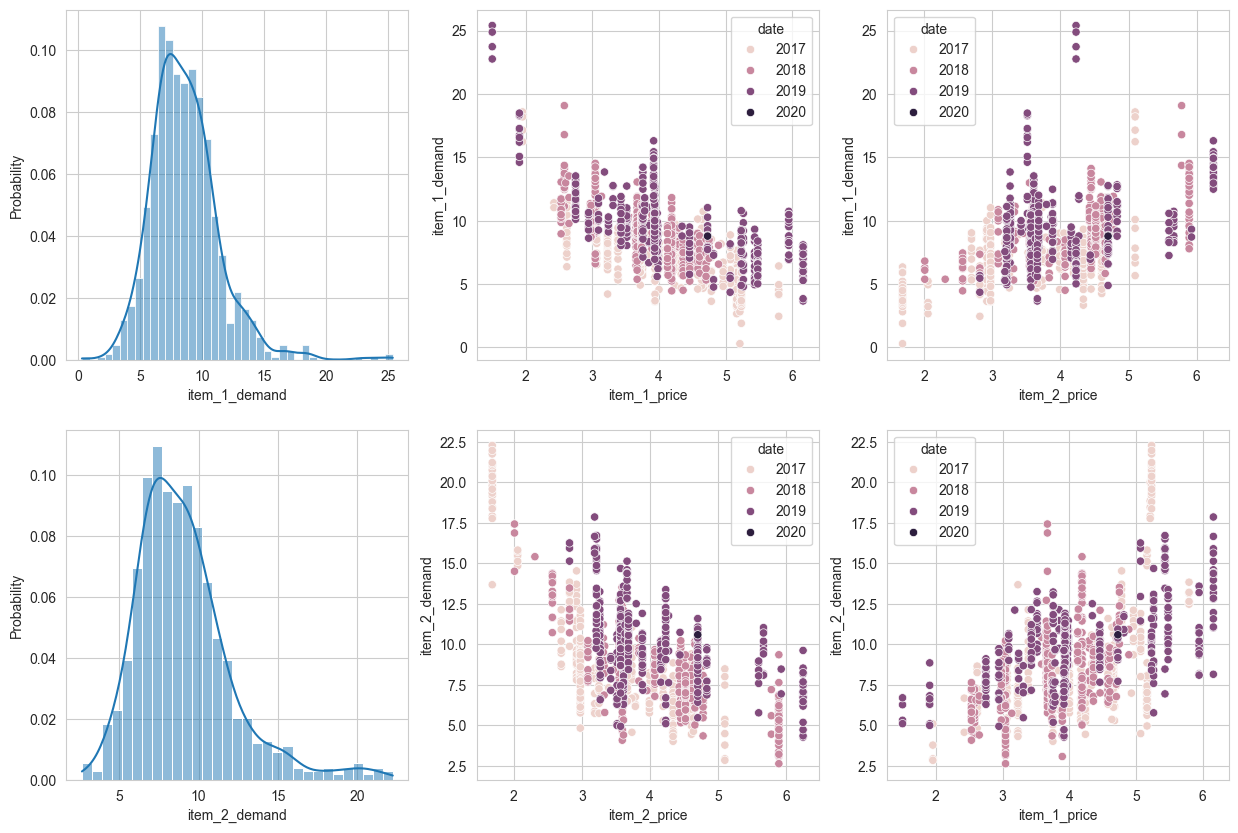

In [28]:
df_vis = df.rename_axis('date').reset_index()
df_vis['date'] = df_vis['date'].dt.year

_, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(n_items):
    sns.histplot(data=df_vis, x=f'item_{i+1}_demand', kde=True, stat='probability', ax=ax[i][0])
    sns.scatterplot(data=df_vis, y=f'item_{i+1}_demand', x=f'item_{i+1}_price', hue='date', ax=ax[i][1])
    sns.scatterplot(data=df_vis, y=f'item_{i+1}_demand', x=f'item_{2-i}_price', hue='date', ax=ax[i][2])

---
## Feature Engineering

We assume that models will be trained separately for each item, so we create a function that produces features for a given item. To limit the number of features, we use the concept of category-average price: instead of modeling pair-wise item interdependencies (which is not scalable), we assume that the demand on a given item depends on the average item price in the category or other aggregates alike.  

In [305]:
def compute_features(data, item_id, all_items):
    df = data.rename_axis('date').reset_index()
    
    demand = df[f'{item_id}_demand']
    demand_lags = pd.concat(
        [df[f'{item_id}_demand'].shift(1, fill_value=np.mean(demand))], 
        axis=1,
        keys=[f'{item_id}_demand_lag1']
    )
    
    calendar = pd.concat([
        df['date'].dt.year - np.min(df['date'].dt.year),
        (df['date'].dt.dayofweek > 4).astype(int),
        df['date'].dt.quarter
    ], axis=1, keys= [
        'year',
        'is_weekend', 
        'quarter'
    ])
    
    own_price = pd.concat([ df[f'{item_id}_price'] ], axis=1)
    avg_price = pd.DataFrame(pd.concat([ df[f'{id}_price'] for id in all_items ], axis=1).mean(axis=1), columns=['avg_price'])
    
    df_xy = pd.concat([demand, demand_lags, own_price, avg_price, calendar], axis=1)
    
    return df_xy

all_items = list(demand_spec['items'].keys())
df_xy = compute_features(df, 'item_1', all_items)
print_df(df_xy)

+----+-----------------+----------------------+----------------+-------------+--------+--------------+-----------+
|    |   item_1_demand |   item_1_demand_lag1 |   item_1_price |   avg_price |   year |   is_weekend |   quarter |
|----+-----------------+----------------------+----------------+-------------+--------+--------------+-----------|
|  0 |         7.48208 |              8.6141  |              4 |     4       |      0 |            1 |         1 |
|  1 |         6.16275 |              7.48208 |              4 |     4       |      0 |            0 |         1 |
|  2 |         4.56507 |              6.16275 |              4 |     3.99421 |      0 |            0 |         1 |
|  3 |         6.2644  |              4.56507 |              4 |     3.99421 |      0 |            0 |         1 |
|  4 |         6.84915 |              6.2644  |              4 |     3.99421 |      0 |            0 |         1 |
|  5 |         6.73715 |              6.84915 |              4 |     3.99421 |  

---
## Aggregated Response Model

In this section, we fit an aggregated market response model (price-response model).

In [286]:
def fit_response_model(data, item_id):
    formula_price = f'np.log({item_id}_demand) ~ np.log({item_id}_price)'
    return smf.ols(formula=formula_price, data=data).fit()

df_xy = compute_features(df, 'item_1', all_items)
response_model = fit_response_model(df_xy, 'item_1')
print(response_model.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(item_1_demand)   R-squared:                       0.377
Model:                               OLS   Adj. R-squared:                  0.376
Method:                    Least Squares   F-statistic:                     661.1
Date:                   Sat, 30 Dec 2023   Prob (F-statistic):          2.01e-114
Time:                           06:35:39   Log-Likelihood:                -72.060
No. Observations:                   1096   AIC:                             148.1
Df Residuals:                       1094   BIC:                             158.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

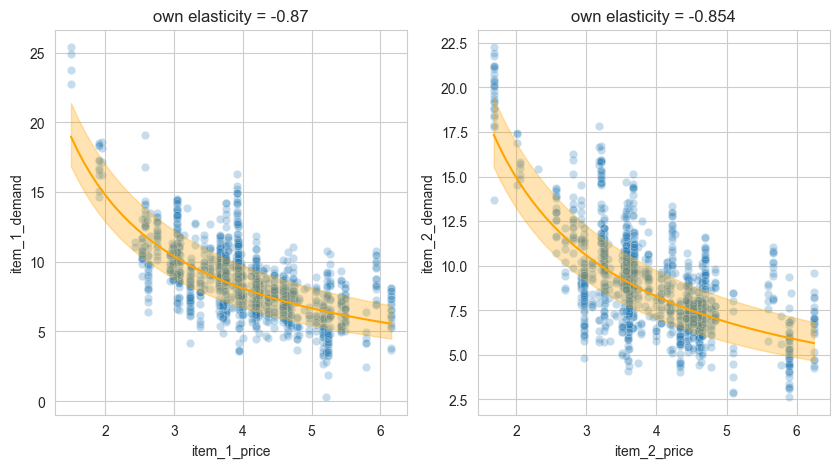

In [307]:
def demand_function(x, e, b):
    return np.exp(b + e * np.log(x))

_, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, item_id in enumerate(all_items):
    df_xy = compute_features(df, item_id, all_items)
    m = fit_response_model(df_xy, item_id)
    c = m.params
    
    x = np.linspace(min(df_xy[f'{item_id}_price']), max(df_xy[f'{item_id}_price']), num=50)
    b_mean, e_mean = c['Intercept'], c[f'np.log({item_id}_price)']
    y = demand_function(x, e_mean, b_mean)
    sns.scatterplot(data=df_xy, y=f'{item_id}_demand', x=f'{item_id}_price',  alpha=0.25, ax=ax[i])
    sns.lineplot(x=x, y=y, ax=ax[i], c='orange')
    
    # Confidence intervals
    conf_int = m.conf_int(alpha=0.05)
    e_conf_int = conf_int.loc[f'np.log({item_id}_price)']
    e_lower, e_upper = e_conf_int[0], e_conf_int[1]
    b_conf_int = conf_int.loc[f'Intercept']
    b_lower, b_upper = b_conf_int[0], b_conf_int[1]
    y_lower, y_upper = demand_function(x, e_lower, b_lower), demand_function(x, e_upper, b_upper)
    ax[i].fill_between(x, y_lower, y_upper, alpha=0.3, color='orange')
    
    ax[i].set_title(f'own elasticity = {e_mean:.3}')

---
## Time Series Forecasting Model

In this section, we fit a time series model and perform in-sample and out-of-sample forecasting.

In [290]:
item_id = 'item_1'
n_holdout = 100

#
# Input data preparation
#
df_xy = compute_features(df, item_id, all_items)
df_train, df_test = df_xy[:-n_holdout], df_xy[-n_holdout:]

inverse_link = np.exp
formula_all = f"""
np.log({item_id}_demand) ~ np.log({item_id}_price) 
                         + np.log(avg_price) 
                         + np.log({item_id}_demand_lag1) 
                         + year 
                         + is_weekend 
                         + C(quarter)
"""
model_all = smf.ols(formula=formula_all, data=df_train).fit()
print(model_all.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(item_1_demand)   R-squared:                       0.741
Model:                               OLS   Adj. R-squared:                  0.739
Method:                    Least Squares   F-statistic:                     352.9
Date:                   Sat, 30 Dec 2023   Prob (F-statistic):          2.63e-283
Time:                           06:36:24   Log-Likelihood:                 380.67
No. Observations:                    996   AIC:                            -743.3
Df Residuals:                        987   BIC:                            -699.2
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

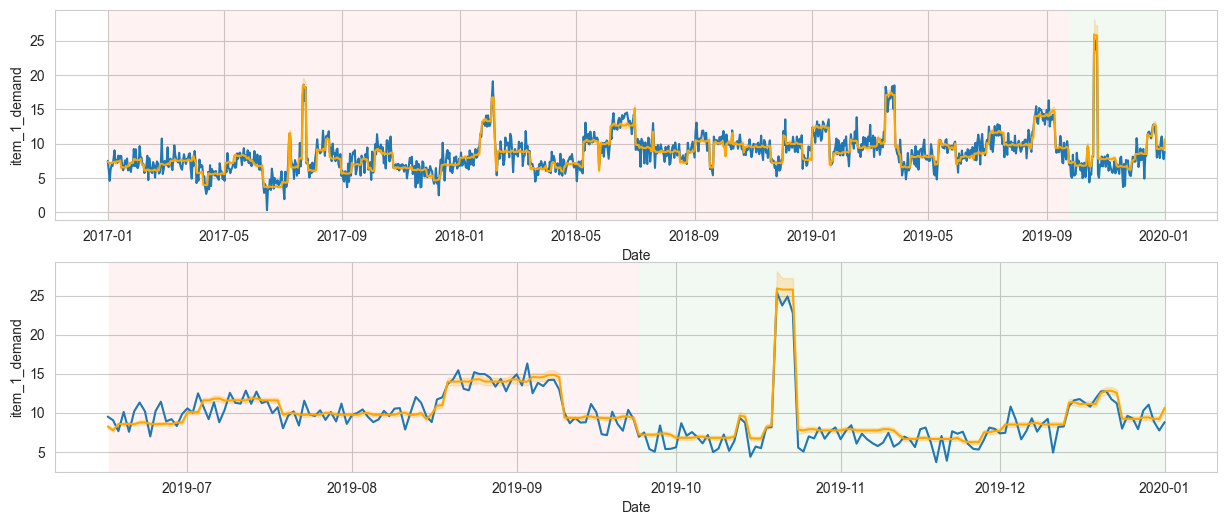

In [303]:
#
# In-sample forecasting
#
in_sample_forecast = inverse_link(model_all.get_prediction(df_train).summary_frame())

# Out-of-sample forecasting: one-step-ahead recursive approach
out_of_sample_forecast = []
demand_t1 = df_train.iloc[-1][f'{item_id}_demand']
for t in range(n_holdout):
    x = pd.DataFrame([df_test.iloc[t]])
    x.iloc[0][f'{item_id}_demand_lag1'] = demand_t1
    y_t = inverse_link(model_all.get_prediction(x).summary_frame().iloc[0])
    out_of_sample_forecast.append(y_t)
    demand_t1 = y_t['mean']

#
# Concatenate the in/out-of-sample forecasts
#
forecast = pd.concat([in_sample_forecast, pd.DataFrame(out_of_sample_forecast)])

def plot_forecast(ax, x, y_true, y_forecast, n_holdout):
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{item_id}_demand')
    ax.grid(True)
    ax.axvspan(x[0], x[-n_holdout], facecolor='red', alpha=0.05)
    ax.axvspan(x[-n_holdout], x[-1], facecolor='green', alpha=0.05)
    ax.plot(x, y_true, c=colors[0])
    ax.plot(x, y_forecast['mean'], c='orange')
    ax.fill_between(x, y_forecast['mean_ci_lower'], y_forecast['mean_ci_upper'], color='orange', alpha=0.25)

#
# Plotting the entire range and  
#
date_index = df.index
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
plot_forecast(ax[0], date_index, df_xy[f'{item_id}_demand'], forecast, n_holdout)
plot_forecast(ax[1], date_index[-2*n_holdout:], df_xy[f'{item_id}_demand'][-2*n_holdout:], forecast[-2*n_holdout:], n_holdout)